<b>Признаки</b>

   - DateCrawled — дата скачивания анкеты из базы
   - VehicleType — тип автомобильного кузова
   - RegistrationYear — год регистрации автомобиля
   - Gearbox — тип коробки передач
   - Power — мощность (л. с.)
   - Model — модель автомобиля
   - Kilometer — пробег (км)
   - RegistrationMonth — месяц регистрации автомобиля
   - FuelType — тип топлива
   - Brand — марка автомобиля
   - NotRepaired — была машина в ремонте или нет
   - DateCreated — дата создания анкеты
   - NumberOfPictures — количество фотографий автомобиля
   - PostalCode — почтовый индекс владельца анкеты (пользователя)
   - LastSeen — дата последней активности пользователя

<b>Целевой признак</b>

- Price — цена (евро)

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
try:
    data_auto=pd.read_csv('desktop/datasets/autos.csv')
except:
    data_auto=pd.read_csv('/datasets/autos.csv')

data_auto.head()  


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
#просмотрим общую информацию о датасете
data_auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Есть пропуски, нужно посмотреть в каком процентном соотношении

In [4]:
#оценим в каком процентном соотношении присутствуют пропуски в датасете
pd.DataFrame(round((data_auto.isna().mean()*100),2)).style.background_gradient('Greens') 

,0
DateCrawled,0.000000
Price,0.000000
VehicleType,10.580000
RegistrationYear,0.000000
Gearbox,5.600000
Power,0.000000
Model,5.560000
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,9.280000


В целом пропусков не более 10% в VehicleType, Gearbox, Model. В столбце NotRepairedБольше всего пропусков пропущенных значение - 20%. Нужно изучить данные, чтобы понять какую стратегию заполнения пропусков (где можно) следует выбрать.

In [5]:
#посмотрим на уникальные значения по столбцам
    
for column in data_auto.columns:
    print('Уникальные значения по столбцу {}'.format(column))
    print()
    print(data_auto[column].unique())
    print()

Уникальные значения по столбцу DateCrawled

['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']

Уникальные значения по столбцу Price

[  480 18300  9800 ... 12395 18429 10985]

Уникальные значения по столбцу VehicleType

[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

Уникальные значения по столбцу RegistrationYear

[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 

['2016-03-24 00:00:00' '2016-03-14 00:00:00' '2016-03-17 00:00:00'
 '2016-03-31 00:00:00' '2016-04-04 00:00:00' '2016-04-01 00:00:00'
 '2016-03-21 00:00:00' '2016-03-26 00:00:00' '2016-04-07 00:00:00'
 '2016-03-15 00:00:00' '2016-03-11 00:00:00' '2016-03-20 00:00:00'
 '2016-03-23 00:00:00' '2016-03-27 00:00:00' '2016-03-12 00:00:00'
 '2016-03-13 00:00:00' '2016-03-18 00:00:00' '2016-03-10 00:00:00'
 '2016-03-07 00:00:00' '2016-03-09 00:00:00' '2016-03-08 00:00:00'
 '2016-04-03 00:00:00' '2016-03-29 00:00:00' '2016-03-25 00:00:00'
 '2016-03-28 00:00:00' '2016-03-30 00:00:00' '2016-03-22 00:00:00'
 '2016-02-09 00:00:00' '2016-03-05 00:00:00' '2016-04-02 00:00:00'
 '2016-03-16 00:00:00' '2016-03-19 00:00:00' '2016-04-05 00:00:00'
 '2016-03-06 00:00:00' '2016-02-12 00:00:00' '2016-03-03 00:00:00'
 '2016-03-01 00:00:00' '2016-03-04 00:00:00' '2016-04-06 00:00:00'
 '2016-02-15 00:00:00' '2016-02-24 00:00:00' '2016-02-27 00:00:00'
 '2015-03-20 00:00:00' '2016-02-28 00:00:00' '2016-02-17 00:00

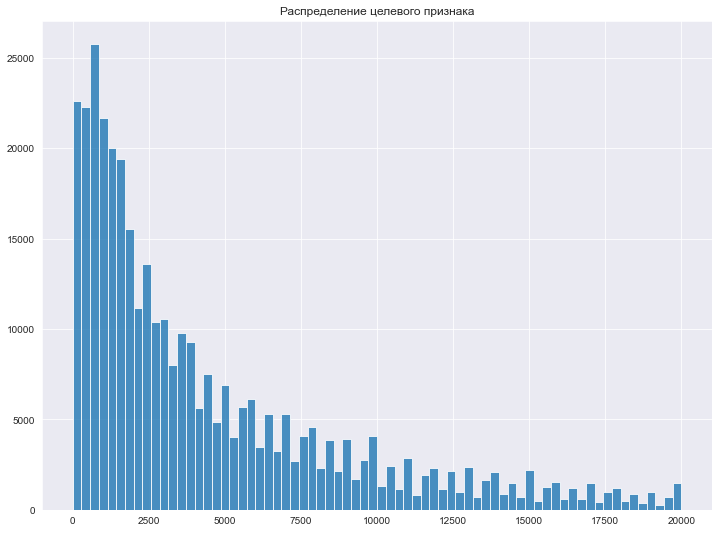

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

In [6]:
#посмотрим на распределение целевого признака
sns.set_style('darkgrid')
data_auto['Price'].hist(bins=70, figsize=(12,9),alpha=0.8)
plt.title('Распределение целевого признака')
plt.show()
data_auto['Price'].describe()

In [7]:
#посмотрим сколько у нас машин с ценой меньше 10 евро
price_data=data_auto.query('0<Price<=10')
price_data.shape

(1340, 16)

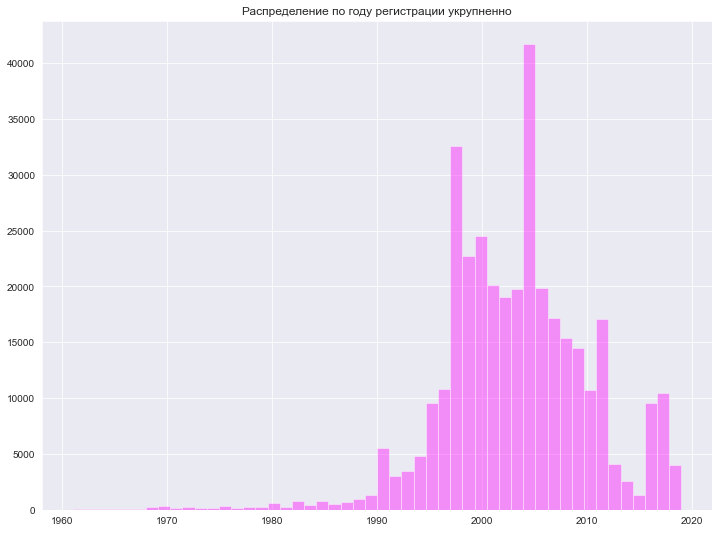

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

In [8]:
#посмотрим на распределение данных по графе "год регистрации" по адекватным годам
data_auto.query('1960<RegistrationYear<=2021')['RegistrationYear'].hist(bins=50, figsize=(12,9), alpha=0.4, color='magenta')
plt.title('Распределение по году регистрации укрупненно')
plt.show()
data_auto['RegistrationYear'].describe()

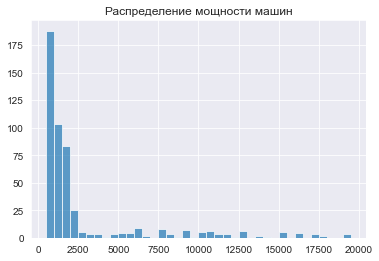

In [9]:
#посмотрим на распределение данных по графе "год регистрации"
data_auto['Power'].describe()
bins_list=[i for i in range(500,20000,500)]
data_auto['Power'].hist(bins=bins_list,alpha=0.7)
plt.title('Распределение мощности машин')
plt.show()

In [10]:
#изучим корреляцию между числовыми признаками и ценой
data_auto[['Price','RegistrationYear','Power','Kilometer']].corr()[['Price']].style.background_gradient('ocean') 

,Price
Price,1.000000
RegistrationYear,0.026916
Power,0.158872
Kilometer,-0.333199


In [11]:
#проверим дубликаты
data_auto.duplicated().sum()

4

In [12]:
#избавимся от дубликатов
data_auto.drop_duplicates(inplace=True)

In [13]:
#превратим дату создания в тип данных "дата", излечем месяц
data_auto['DateCreated']=pd.to_datetime(data_auto['DateCreated'],format='%Y-%m-%d')
data_auto['MonthCreated']=data_auto['DateCreated'].dt.month
data_auto['YearCreated']=data_auto['DateCreated'].dt.year


In [14]:
data_auto['MonthCreated'].value_counts()


3     296756
4      57118
2        397
1         70
11         9
12         9
9          3
8          2
6          1
Name: MonthCreated, dtype: int64

In [15]:
data_auto['YearCreated'].value_counts()

2016    354339
2015        25
2014         1
Name: YearCreated, dtype: int64

<b>Выводы по изучению данных</b>
1. В датасете есть пропуски в категориальных данных в столбцах:

VehicleType ~ 11%
Gearbox  ~6%  
Model  ~ 6%  
FuelType  ~9%  
NotRepaired  ~20%
    
Для столбцов, где пропусков меньше 10% заменим на наиболее популярное значение. Поставим в столбце <b>NotRepaire</b> вместо NaN “unknown”

2. Обнаружено 4 дубликата
3. В столбце <b>Power</b> есть нулевые значения, а также некорректные значения.
После поиска в google установлено, что самая маломощная на сегодняшний день машина имела  4,2 л.с., а самая мощная 5000 л.с., ограничимся подобными значениями.

5. В столбце <b>RegistrationYear</b> есть некорректные значения, изучив распределение, выберем диапазон в пределах 1960 г – 2021 г

6. В целевом признаке <b>Price</b> обнаружены нулевые значения, а так же 1340 объектов с ценой меньше 10 евро. В целом посмотрев по сайтам продажи авто, продают и за 1000 р (~12евро), но это металлолом. Данных в целом не много, в качестве эксперимента можно попробовать впоследствии обучить модели, исключив эти данные. 

7. К значимым признакам отнесем следующие столбцы:

    - <b>VehicleType</b> – от типа кузова зависит стоимость
    - <b>Gearbox</b> – тип коробки передач влияет на стоимость, автомат обычно дороже механики.
    - <b>Power</b> – чем мощнее, тем дороже (корреляция это подтвердила)
    - <b>Kilometer</b> – чем больше км прошла машина, тем она дешевле (на графике корреляции эта зависимость видна)
    - <b>FuelType</b> – тип топлива влияет на цену, так как в совокупности означает сколько будет стоить эксплуатация
    - <b>Brand</b> – бренд влияет на цену
    - <b>NotRepaired</b> – если была в починке, цена будет ниже
    - <b>RegistrationYear</b> – чем старше, тем дешевле;
    - <b>Model</b> – так же как и бренд, модель влияет на цену.
        

### Предобработка

In [16]:
#выберем  из датасета значимые столбцы
good_data_auto=data_auto[['VehicleType','Gearbox','Power','Kilometer','FuelType','Brand','NotRepaired','RegistrationYear','Model','Price']]
good_data_auto.head()

,VehicleType,Gearbox,Power,Kilometer,FuelType,Brand,NotRepaired,RegistrationYear,Model,Price
0,NaN,manual,0,150000,petrol,volkswagen,NaN,1993,golf,480
1,coupe,manual,190,125000,gasoline,audi,yes,2011,NaN,18300
2,suv,auto,163,125000,gasoline,jeep,NaN,2004,grand,9800
3,small,manual,75,150000,petrol,volkswagen,no,2001,golf,1500
4,small,manual,69,90000,gasoline,skoda,no,2008,fabia,3600


In [17]:
#выясним популярные значения по столбцам с пропущенными данными
for ithem in ['VehicleType','Gearbox','FuelType','Model']:  
    print('Для столбца  "{}"'.format(ithem), good_data_auto[ithem].mode())

Для столбца  "VehicleType" 0    sedan
dtype: object
Для столбца  "Gearbox" 0    manual
dtype: object
Для столбца  "FuelType" 0    petrol
dtype: object
Для столбца  "Model" 0    golf
dtype: object


In [18]:
#VehicleType-> на популярное значение
good_data_auto['VehicleType']=good_data_auto['VehicleType'].fillna(value='sedan')

#Gearbox -> на популярное значение
good_data_auto['Gearbox']=good_data_auto['Gearbox'].fillna(value='manual')

#FuelType -> на популярное значение
good_data_auto['FuelType']=good_data_auto['FuelType'].fillna(value='petrol')

#Model -> на популярное значение455r4
good_data_auto['Model']=good_data_auto['Model'].fillna(value='golf')

#NotRepaired -> на unknown
good_data_auto['NotRepaired']=good_data_auto['NotRepaired'].fillna(value='unknown')

In [19]:
#проверим наличие пропусков
pd.DataFrame(round((good_data_auto.isna().mean()*100),2)).style.background_gradient('Greens') 

,0
VehicleType,0.000000
Gearbox,0.000000
Power,0.000000
Kilometer,0.000000
FuelType,0.000000
Brand,0.000000
NotRepaired,0.000000
RegistrationYear,0.000000
Model,0.000000
Price,0.000000


In [20]:
#выберем данные с корректными значениями по столбцам Power и RegistrationYear
good_data_auto=good_data_auto.query('1960<=RegistrationYear<=2021 and 4.2<=Power<=5000')
#по целевому столбцу уберем 
good_data_auto=good_data_auto.query('Price>0')

In [21]:
#посмотрим что у нас осталось после предобработки
good_data_auto.shape

(306892, 10)

In [22]:
#посмотрим описание, чтобы оценить корректно ли отработала выборка значений
good_data_auto.describe()

,Power,Kilometer,RegistrationYear,Price
count,306892.000000,306892.000000,306892.000000,306892.000000
mean,121.419679,128466.040170,2003.326454,4808.416759
std,69.517242,36688.322822,6.842817,4585.116282
min,5.000000,5000.000000,1960.000000,1.000000
25%,75.000000,125000.000000,1999.000000,1300.000000
50%,110.000000,150000.000000,2003.000000,3100.000000
75%,150.000000,150000.000000,2008.000000,6950.000000
max,4700.000000,150000.000000,2019.000000,20000.000000


In [23]:
#проверяем размерности
good_data_auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306892 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       306892 non-null  object
 1   Gearbox           306892 non-null  object
 2   Power             306892 non-null  int64 
 3   Kilometer         306892 non-null  int64 
 4   FuelType          306892 non-null  object
 5   Brand             306892 non-null  object
 6   NotRepaired       306892 non-null  object
 7   RegistrationYear  306892 non-null  int64 
 8   Model             306892 non-null  object
 9   Price             306892 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 25.8+ MB


### Обучение моделей

In [24]:
#OHE-кодирование
auto_ohe = good_data_auto
auto_ohe = pd.get_dummies(auto_ohe,drop_first=True)

auto_categ = good_data_auto
auto_categ = auto_categ.astype({"VehicleType":'category',"Gearbox":'category',"Model":'category',"FuelType":'category',"Brand":'category',"NotRepaired":'category'})

In [25]:
#выделим feauters и target

#OHE
feauters_ohe=auto_ohe.drop('Price',axis=1)
target_ohe=auto_ohe['Price']
#+Categorial
feauters_categ=auto_categ.drop(['Price'],axis=1)
target_categ=auto_categ['Price']
#Real
feauters_real=good_data_auto.drop(['Price'],axis=1)
target_real=good_data_auto['Price']

#и разделим

#OHE
feauters_train_ohe,feauters_test_ohe,target_train_ohe,target_test_ohe= train_test_split(feauters_ohe,target_ohe,test_size = 0.25,random_state = 12345)
#+Categorial
feauters_train_categ,feauters_test_categ,target_train_categ,target_test_categ = train_test_split(feauters_categ,target_categ,test_size = 0.25,random_state = 12345)
#Real
feauters_train_real,feauters_test_real,target_train_real,target_test_real= train_test_split(feauters_real,target_real,test_size = 0.25,random_state = 12345)

Будем обучать и сравнивать две модели:
  - RandomForestRegressor
  - LightGBM
  - CatboostRegressor

In [26]:

%%time

#LightGBM
lgb_regressor = LGBMRegressor() 
lgb_param = {'max_depth':list(range(15, 31, 5)) + [-1],
             'n_estimators': range(200, 601, 30),
             'learning_rate': [0.2],
             'random_state':[12345]}

#обучаем
lgb_model = RandomizedSearchCV(lgb_regressor, param_distributions =lgb_param,scoring='neg_root_mean_squared_error', cv=3,random_state=12345)
lgb_model.fit(feauters_train_categ, target_train_categ)


CPU times: user 6min 13s, sys: 4.45 s, total: 6min 17s
Wall time: 48.9 s


RandomizedSearchCV(cv=3, estimator=LGBMRegressor(),
                   param_distributions={'learning_rate': [0.2],
                                        'max_depth': [15, 20, 25, 30, -1],
                                        'n_estimators': range(200, 601, 30),
                                        'random_state': [12345]},
                   random_state=12345, scoring='neg_root_mean_squared_error')

In [27]:
#лучшие параметры
print('Лучшие параметры для LightGBM',lgb_model.best_params_)

Лучшие параметры для LightGBM {'random_state': 12345, 'n_estimators': 530, 'max_depth': 30, 'learning_rate': 0.2}


In [28]:
#RMSE
print('Лучшее значение RMSE для LightGBM')
print((lgb_model.best_score_*(-1)))


Лучшее значение RMSE для LightGBM
1577.6231176831614


In [ ]:
%%time
# catboost

cat_regressor=CatBoostRegressor(verbose=False, 
                                cat_features=['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired'])
#параметры
param_cat = {'max_depth':range(5, 25),
             'n_estimators': range(5,20),
             'learning_rate': [0.2]}

#обучаем
cat_model = RandomizedSearchCV(cat_regressor, param_distributions = param_cat, scoring='neg_root_mean_squared_error', cv=5)
cat_model.fit(feauters_train_real, target_train_real)

In [30]:
#лучшие параметры Catboost
print('Лучшие параметры для CatBoost',cat_model.best_params_)

Лучшие параметры для CatBoost {'n_estimators': 18, 'max_depth': 14, 'learning_rate': 0.2}


In [31]:
#лучшая RMSE оценка для Catboost
print('Лучшее значение RMSE для Catboost')
print((cat_model.best_score_*-1))

Лучшее значение RMSE для Catboost
1755.5016632626964


### Проверим на тесте с лучшими параметрами


<b> ВЫВОД: </b>

В ходе работы было выполнено:
1.	Загружены, изучены данные и проведена предобработка.
- были обнаружены и обработаны пропуски в данных;
- устранены некорректные и нулевые значения;
- были обнаружены и устранены дубликаты;
- выделены столбцы со значимыми для обучения данными.
2.	Выполнено сравнение трех моделей:
- RandomForestRegressor
- LightGBM
- CatboostRegressor
+ использованы различные наборы гиперпараметров.
3.	Выбрана лучшая модель по результатам метрики RMSE и времени обучения (на тестовой выборке).
- Лидером оказалась модель <b>LightGBM</b> (Wall time=1.37 s, RMSE=1528.12)
- На втором месте <b>CatboostRegressor</b> (Wall time=736 ms, RMSE=2037.65), однако модель оказалась быстрее всех!
- Наиболее медленно и наименее точно предсказал <b>RandomForestRegressor</b> (Wall time=25.9 s, RMSE=2448.89)


    